# Setting

In [1]:
import ast
import csv
import glob
from io import StringIO
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydicom
import time
from tqdm import tqdm_notebook
from tqdm import trange

from source.data_loader import MyDataLoader
from source.my3dpix2pix import My3dPix2Pix

# Dataframe from dicoms
dicom/YOURDATASET should be in following format:<br>
YOURDATASET<br>
&nbsp;&nbsp;&nbsp;&nbsp;case1<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CT1 containing dicom files<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CT2 containing dicom files<br>
&nbsp;&nbsp;&nbsp;&nbsp;case2<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CT1 containing dicom files<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CT2 containing dicom files<br>
&nbsp;&nbsp;&nbsp;&nbsp;...

In [2]:
def my_dicoms_to_dataframe(basedir, cts):
    caselist = [os.path.join(basedir, x) for x in os.listdir(basedir) if os.path.isdir(os.path.join(basedir, x))]
    file_list = []
    for x in cts:
        file_list.extend(glob.glob(os.path.join(basedir, '*/' + x + '/*.*')))

    tdcmpath = os.path.join(caselist[0], cts[0])
    tdcmpath = [os.path.join(tdcmpath, x) for x in os.listdir(tdcmpath)][0]
    # tdcmpath = [os.path.join(tdcmpath, x) for x in os.listdir(tdcmpath) if x.lower().endswith('.dcm')][0]
    tdcm = pydicom.dcmread(tdcmpath, stop_before_pixels=True)

    headers = []
    headers.append('filepath')

    for x in tdcm:
        if x.name == 'Pixel Data':
            continue
        elif 'Overlay' in x.name or 'Referring' in x.name or 'Acquisition' in x.name:
            continue
        else:
            name = x.name.replace(' ', '')
            headers.append(name)

    output = StringIO()
    csv_writer = csv.DictWriter(output, fieldnames=headers)
    csv_writer.writeheader()

    for f in file_list:
        file = pydicom.dcmread(f, stop_before_pixels=True)

        row = {}
        for x in file:
            row['filepath'] = f
            if x.name == 'Pixel Data':
                continue
            elif 'Overlay' in x.name or 'Referring' in x.name or 'Acquisition' in x.name:
                continue
            else:
                name = x.name.replace(' ', '')
                row[name] = x.value
        unwanted = set(row) - set(headers)
        for unwanted_key in unwanted: del row[unwanted_key]
        csv_writer.writerow(row)

    output.seek(0)  # we need to get back to the start of the StringIO
    df = pd.read_csv(output, low_memory=False)

    df['pid'] = df['filepath'].apply(lambda x: x.split(os.sep)[-3])
    df['ct'] = df['filepath'].apply(lambda x: x.split(os.sep)[-2])
    df['zpos'] = df['ImagePosition(Patient)'].apply(lambda x: [str(n).strip() for n in ast.literal_eval(x)][-1])

    cols = df.columns.tolist()
    cols = cols[-3:] + cols[:-3]
    df = df[cols]

    df.to_feather(os.path.join(basedir, 'headers.ftr'))
    return df

## Train data

In [3]:
# CT1 = input, CT2 = output

train_dir = 'C:/Users/einspaen/AppData/Local/xnat-dataset/cnn-train-test'
cts = ('fill','sub')
df = my_dicoms_to_dataframe(train_dir, cts)

In [4]:
#### modify headers and save

df['zpos'] = df['zpos'].apply(pd.to_numeric)
df = df.sort_values(by=['pid', 'ct', 'zpos'])
df2 = df.reset_index(drop=True)
df2path = os.path.join(train_dir, 'select.ftr')
df2.to_feather(df2path)

## Validation data

In [5]:
# CT1 = input, CT2 = output
val_dir = 'C:/Users/einspaen/AppData/Local/xnat-dataset/cnn-validation-test'
cts = ('fill','sub')
df = my_dicoms_to_dataframe(val_dir, cts)

In [6]:
#### modify headers and save

df['zpos'] = df['zpos'].apply(pd.to_numeric)
df = df.sort_values(by=['pid', 'ct', 'zpos'])
df2 = df.reset_index(drop=True)
df2path = os.path.join(val_dir, 'select.ftr')
df2.to_feather(df2path)

# Get data loader

## For new configuration and new result folder

In [7]:
## new config
import config as c

base_dir = 'C:/Users/einspaen/AppData/Local/xnat-dataset'
train_dir = 'C:/Users/einspaen/AppData/Local/xnat-dataset/cnn-train-test'
val_dir = 'C:/Users/einspaen/AppData/Local/xnat-dataset/cnn-validation-test'

cfg = {
    'df_path': os.path.join(train_dir, 'select.ftr'),
    'cts':('fill','sub'),
    'img_shape':c.img_shape,
    'window1':[(2000,0),(1000,200),(500,50)],
    'window2':[(2000,0),(1000,200),(500,50)],
    'batch_size':1,
    'epochs':2,
    'opt':'adam',
    'lrs':(0.0002, 0.1),
    'L_weights':(1,100),
    'sample_interval':8,
    'model_interval':5,
    ## default
    'grid':(1,1,1),
    'splitvar':1.0,
    'resizeconv':True,
    'smoothlabel':True,
    'rescale_intensity':False,
    ## below not used
    'coordconv':False,
    'randomshift':0.1,
    'gennoise':0,
    'dropout':0.0,
    'resoutput':0.0,
    'fmloss':False,
    'multigpu':None,
}

In [8]:
df0 = pd.read_feather(cfg['df_path'])

In [9]:
print('Start: Load Data')
DL = MyDataLoader(df0, cts=cfg['cts'], img_shape=cfg['img_shape'],
                  grid=cfg['grid'],
                  window1=cfg['window1'], window2=cfg['window2'], rescale_intensity=cfg['rescale_intensity'], splitvar=cfg['splitvar'])
print('Finish: Load Data')


Start: Load Data
pid
163284441-2    394
164339612-3    394
Name: slice_num, dtype: int32
[('163284441-2', 394), ('164339612-3', 394)]
Finish: Load Data


In [10]:
### save new config in new folder

spath = base_dir + '/result'
if not os.path.isdir(spath):
    os.makedirs(spath)
    
split_path = os.path.join(spath, 'split.pkl')
DL.save_split(split_path)
cfg['splitvar'] = split_path
    
with open(os.path.join(spath,'cfg.json'), 'w') as json_file:
    json.dump(cfg, json_file)

In [11]:
gan = My3dPix2Pix(DL, savepath=spath, L_weights=cfg['L_weights'], opt=cfg['opt'], lrs=cfg['lrs'],
                  smoothlabel=cfg['smoothlabel'], fmloss=cfg['fmloss'],
                  gennoise=cfg['gennoise'],
                  randomshift=cfg['randomshift'], resoutput=cfg['resoutput'], dropout=cfg['dropout'],
                  coordconv=cfg['coordconv'], resizeconv=cfg['resizeconv'], multigpu=cfg['multigpu'])

Optimizer:  <keras.src.optimizers.adam.Adam object at 0x000001A6555C1220>


## Load from saved

In [ ]:
## load config
spath = 'result/YOURFOLDER'
with open(os.path.join(spath, 'cfg.json')) as json_file:
    cfg = json.load(json_file)

In [ ]:
%%time
df0 = pd.read_feather(cfg['df_path'])
DL = MyDataLoader(df0, cts=cfg['cts'], img_shape=cfg['img_shape'],
                  grid=cfg['grid'],
                  window1=cfg['window1'], window2=cfg['window2'], rescale_intensity=cfg['rescale_intensity'], splitvar=cfg['splitvar'])

In [ ]:
%%time
gan = My3dPix2Pix(DL, savepath=spath, L_weights=cfg['L_weights'], opt=cfg['opt'], lrs=cfg['lrs'],
                  smoothlabel=cfg['smoothlabel'], fmloss=cfg['fmloss'],
                  gennoise=cfg['gennoise'],
                  randomshift=cfg['randomshift'], resoutput=cfg['resoutput'], dropout=cfg['dropout'],
                  coordconv=cfg['coordconv'], resizeconv=cfg['resizeconv'], multigpu=cfg['multigpu'])

# Train

In [12]:
gan.train(epochs=cfg['epochs'], batch_size=cfg['batch_size'], sample_interval=cfg['sample_interval'], model_interval=cfg['model_interval'])

1/1 [==============================] - 4s 4s/step
[Epoch 1/2] [Batch 1/79152150] [D loss: 8.847814, D fake: 8.076205] [G loss: 0.000000] time: 0:00:15.437541
1/1 [==============================] - 4s 4s/step
[Epoch 1/2] [Batch 2/79152150] [D loss: 0.382920, D fake: 0.000752] [G loss: 0.000000] time: 0:00:22.241136
1/1 [==============================] - 5s 5s/step
[Epoch 1/2] [Batch 3/79152150] [D loss: 9.831788, D fake: 0.068232] [G loss: 0.000000] time: 0:00:30.019121
1/1 [==============================] - 4s 4s/step
[Epoch 1/2] [Batch 4/79152150] [D loss: 0.579930, D fake: 0.055552] [G loss: 0.000000] time: 0:00:36.607573
1/1 [==============================] - 4s 4s/step
[Epoch 1/2] [Batch 5/79152150] [D loss: 0.483804, D fake: 0.008269] [G loss: 0.000000] time: 0:00:42.512721
1/1 [==============================] - 4s 4s/step
[Epoch 1/2] [Batch 6/79152150] [D loss: 0.395461, D fake: 0.029507] [G loss: 0.000000] time: 0:00:48.406950
1/1 [==============================] - 4s 4s/step
[E

KeyboardInterrupt: 

In [ ]:
# view log
#spath = 'result/YOURFOLDER'

In [13]:
epoch = []
batch = []
dloss = []
gloss = []
time = []
with open(os.path.join(spath,'log.txt'), 'r') as f:
    for line in f.readlines():
        line = line.strip()
        e,b,d,g,t = line.split('] ')
        e = e.replace('[Epoch ','').split('/')[0]
        b = b.replace('[Batch ','').split('/')[0]
        d = d.replace('[D loss: ','').split(',')[0]
        g = g.replace('[G loss: ','')
        t = t.replace('time: ','')
        
        epoch.append(int(e))
        batch.append(int(b))
        dloss.append(float(d))
        gloss.append(float(g))
        time.append(t)

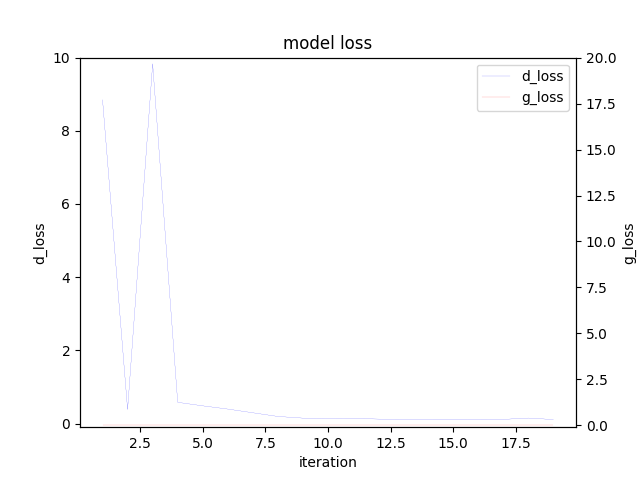

In [16]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111)

x = np.arange(len(dloss)) + 1

ax.plot(x, dloss, '-b', linewidth=0.1, label='d_loss')
ax2 = ax.twinx()
ax2.plot(x, gloss, '-r', linewidth=0.1, label='g_loss')
ax.set_ylim(-0.1,10)
ax2.set_ylim(-0.1,20)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax.set_title('model loss')
ax.set_ylabel('d_loss')
ax2.set_ylabel('g_loss')
ax.set_xlabel('iteration')
#fig.savefig(os.path.join(spath, 'loss.png'))
plt.show()